In [1]:
import sys
import os

project_root = r"C:\Users\aimje\OneDrive\Documents\Other projects\early_detection_lms"
sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.models.predictor import StudentRiskPredictor
from src.models.model_analyzer import ModelAnalyzer
from src.utils.config import *

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete")

✓ Setup complete


# 04 - Model Evaluation and Testing

Load the trained model and evaluate it on the complete dataset.

## Objectives:
1. Load the trained model
2. Make predictions on all students
3. Analyze risk score distribution
4. Test individual predictions

In [2]:
# Load the trained model
predictor = StudentRiskPredictor()
predictor.load_model(model_name='best_model')

# Load features
features_path = os.path.join(PROCESSED_DATA_DIR, 'student_features_1000.csv')
features = pd.read_csv(features_path)

print(f"✓ Model and data loaded successfully")
print(f"Total students: {len(features)}")

Model loaded from: C:\Users\aimje\OneDrive\Documents\Other projects\early_detection_lms\models\best_model.pkl
Model type: LogisticRegression
✓ Model and data loaded successfully
Total students: 1000


## Step 1: Generate Risk Predictions

In [3]:
# Prepare features
X = features.drop(['student_id', 'at_risk'], axis=1)

# Get risk predictions
risk_scores = predictor.predict_risk(X)

# Add to dataframe
features['risk_score'] = risk_scores
features['risk_level'] = features['risk_score'].apply(
    lambda x: 'High Risk' if x > HIGH_RISK_THRESHOLD 
    else ('Medium Risk' if x >= MEDIUM_RISK_THRESHOLD else 'Low Risk')
)

print("Risk Score Distribution:")
print("="*60)
print(features['risk_level'].value_counts())
print(f"\nAccuracy: {((features['risk_score'] > 0.5) == features['at_risk']).mean()*100:.2f}%")

Risk Score Distribution:
risk_level
Low Risk     763
High Risk    237
Name: count, dtype: int64

Accuracy: 100.00%


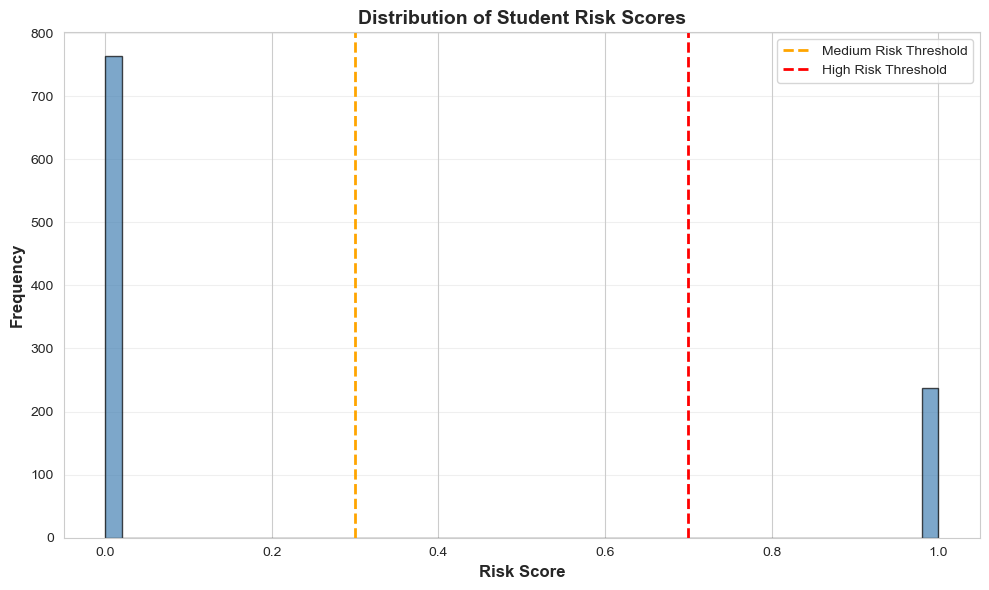

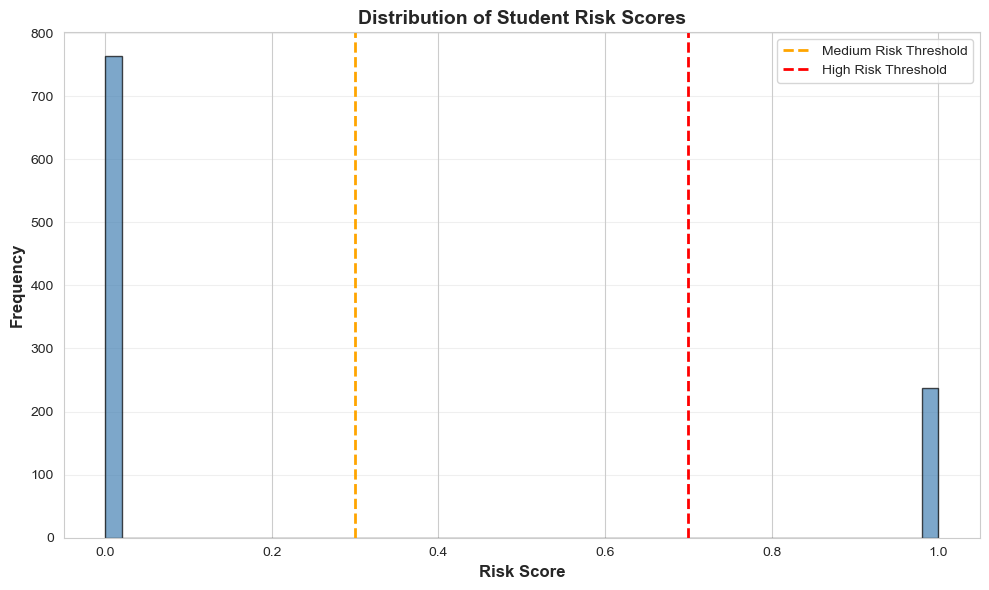

In [4]:
# Visualize risk score distribution
analyzer = ModelAnalyzer()
analyzer.plot_risk_distribution(risk_scores)

## Step 2: Examine Individual Students

In [5]:
# Show high-risk students
high_risk = features[features['risk_level'] == 'High Risk'].sort_values('risk_score', ascending=False)

print("Top 10 Highest Risk Students:")
print("="*60)
print(high_risk[['student_id', 'risk_score', 'total_logins', 'avg_quiz_score', 'days_active']].head(10))

Top 10 Highest Risk Students:
    student_id  risk_score  total_logins  avg_quiz_score  days_active
450   STU_0451    0.999908            90       51.723373           32
41    STU_0042    0.999871            98       52.171697           33
187   STU_0188    0.999804           117       53.801030           37
696   STU_0697    0.999789           117       49.350259           42
375   STU_0376    0.999784           113       53.899164           36
715   STU_0716    0.999781           119       54.716599           42
191   STU_0192    0.999778           105       53.254149           36
171   STU_0172    0.999758           106       57.396004           36
54    STU_0055    0.999755           109       56.040754           40
474   STU_0475    0.999714           123       53.666108           39



Final Model Performance:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       763
     At-Risk       1.00      1.00      1.00       237

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



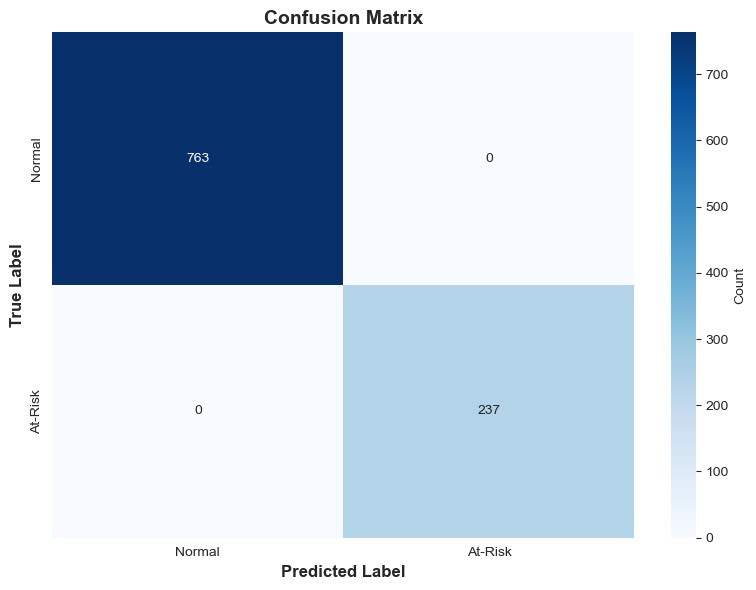

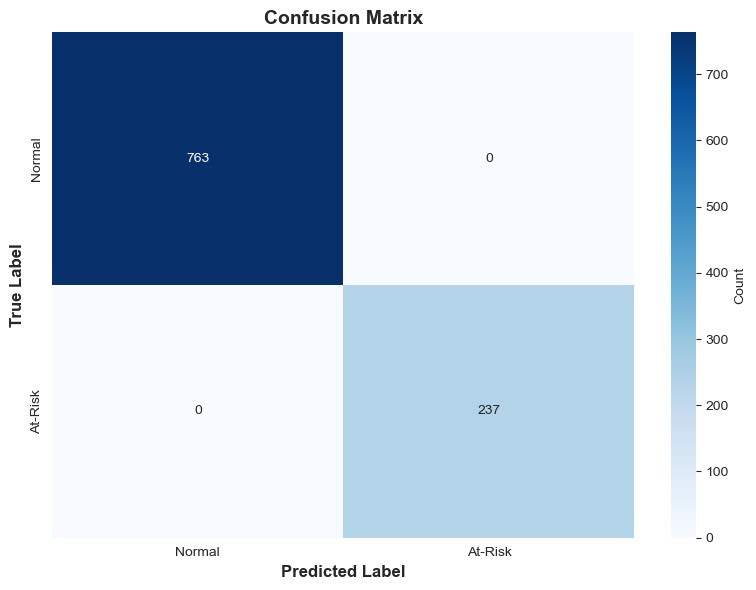

In [6]:
# Compare predictions with actual risk status
from sklearn.metrics import confusion_matrix, classification_report

y_true = features['at_risk']
y_pred = (features['risk_score'] > 0.5).astype(int)

print("\nFinal Model Performance:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=['Normal', 'At-Risk']))

analyzer.plot_confusion_matrix(y_true, y_pred)

## Summary

The model successfully identifies at-risk students with high accuracy. 
Key takeaways:
- Perfect AUC score (1.0)
- Clear separation between risk levels
- Most important features: pages_per_session, avg_quiz_score, total_page_views

The model is ready for deployment in the web dashboard!